In [1]:
import numpy as np
from matplotlib import figure, gridspec,colors

import scanner_interpretation as scani

import healpy as hp

from matplotlib import colors,cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization as vis

import dill



# bands = ["u_5_15", "u_15_25", "u_25_35", "u_35_45", "u_45_55", "u_55_65", "u_65_75", "u_75_90", "l_15_5", "l_25_15", "l_35_25", "l_45_35", "l_55_45", "l_65_55", "l_75_65", "l_90_75", "center"]
# versions = ["hess1","hess1u"]
# paths = [f"/lustre/fs22/group/hess/user/wybouwt/full_scanner_survey/{version}/{band}" for band in bands for version in versions]
# # mplets = scani.Multiplets(paths[0])
# # mplets.appendMultiplets(*[scani.Multiplets(path) for path in paths[1:]])
# mplet_list = [scani.Multiplets(path) for path in paths]


# unicorns = [9,18]
# for j in unicorns:
#     mplet_list[j].objectifyColumns()

    
# mplets = mplet_list[0]
# mplets.appendMultiplets(*mplet_list[1:])
with open("pkl_jugs/mplets.pkl","rb") as f:
    mplets = dill.load(f)

nosource_mask = mplets.table["TEVCAT_DISTANCES_DEG"] >= 0.2
Nmin4_mask = mplets.table["Nmax"] >= 4
Nmin5_mask = mplets.table["Nmax"] >= 5
dt1sec_mask = mplets.table["dt"] <= 1e9
xgal_mask = np.abs(mplets.table["MEDIAN_GLAT"]) > 5

In [4]:
scani.get_total_runcount(scani.getDataStores())

23940

In [17]:
pks2155_mask = mplets.table["TEVCAT_SOURCE_NAME"] == "PKS 2155-304"
mkr421_mask = mplets.table["TEVCAT_SOURCE_NAME"] == "Markarian 421"
mplets.table[mkr421_mask * ~nosource_mask]
# g = vis.hist(mplets.table[mkr421_mask * ~nosource_mask]["Nmax"],histtype="step")
# plt.yscale("log")

Nmax,OBS_ID,ID,RA,DEC,TIME,ENERGY,dt,da,MEDIAN_RA,MEDIAN_DEC,SkyCoord,MEDIAN_GLAT,MEDIAN_GLON,TEVCAT_SOURCE_NAME,TEVCAT_SOURCE_TYPE,TEVCAT_DISTANCES_DEG,DS_INDEX,ANGULAR_MEASURE_DEG
,,,,,,,,,,,"deg,deg",deg,deg,,,,,
int64,uint32,object,object,object,object,object,float64,float64,float64,float64,SkyCoord,float64,float64,str21,str22,float64,int64,float64
3,18605,[322122547255 322122547307 322122547757],[165.91216 166.0204 166.08354],[38.353996 38.269028 38.389893],['2004-01-28T00:53:59.476032550' '2004-01-28T00:53:59.797567183'\n '2004-01-28T00:54:02.315361077'],[1.5224578 1.7962043 1.5711279],2839328512.0,0.17811506897940851,166.02040100097656,38.35399627685547,"166.02040100097656,38.35399627685547",64.9158802725177,179.56125494296282,Markarian 421,HBL,0.16976933746502942,0,0.07699970416456951
3,20234,[3259880177877 3259880178027 3259880178104],[165.93379 166.07498 165.90515],[38.33831 38.210537 38.29355 ],['2004-04-12T20:42:48.971211964' '2004-04-12T20:42:49.821955496'\n '2004-04-12T20:42:50.309283787'],[1.3899164 1.5522218 1.0998622],1338071936.0,0.19167847364628332,165.9337921142578,38.293548583984375,"165.9337921142578,38.293548583984375",64.87060300157327,179.74713673653358,Markarian 421,HBL,0.17578512527291665,0,0.06858450323535686
3,20235,[3856880632379 3861175599149 3861175599408],[166.20781 166.07423 166.09448],[38.15459 38.226448 38.226055],['2004-04-12T20:54:27.853294427' '2004-04-12T20:54:28.543241793'\n '2004-04-12T20:54:30.270674521'],[3.1700668 1.2933309 1.5797087],2417380096.0,0.15167693130284216,166.094482421875,38.22605514526367,"166.094482421875,38.22605514526367",65.01163095790604,179.8043298225054,Markarian 421,HBL,0.03487584298513405,0,0.04336960095572886
3,20259,[1503238553660 1503238553709 1503238553833],[166.22221 166.22089 166.25148],[38.162125 38.324497 38.204163],['2004-04-13T21:08:26.294925267' '2004-04-13T21:08:26.717297846'\n '2004-04-13T21:08:27.647982413'],[1.0999688 1.4418122 1.6454508],1353057152.0,0.16237801572213525,166.2222137451172,38.20416259765625,"166.2222137451172,38.20416259765625",65.11375459584958,179.7781634828815,Markarian 421,HBL,0.14335824825090906,0,0.061789993588818835
3,20260,[3710851743944 3710851744166 3715146711085],[166.23222 166.13957 166.10861],[38.22925 38.186382 38.235764],['2004-04-13T21:45:23.912197405' '2004-04-13T21:45:26.096063906'\n '2004-04-13T21:45:26.858544404'],[8.770012 2.9416454 2.420378 ],2946347008.0,0.12378284494639992,166.1395721435547,38.229251861572266,"166.1395721435547,38.229251861572266",65.04421935858542,179.77059511635633,Markarian 421,HBL,0.0695781404732507,0,0.04694285395309573
3,20260,[3161095930210 3165390897161 3165390897284],[165.98631 166.12744 166.10907],[38.200237 38.2309 38.2263 ],['2004-04-13T21:36:49.966964776' '2004-04-13T21:36:51.261952693'\n '2004-04-13T21:36:52.361953551'],[1.0227865 1.9116696 4.0161214],2394988800.0,0.14442110637160063,166.10906982421875,38.22629928588867,"166.10906982421875,38.22629928588867",65.02242557656942,179.79520393974198,Markarian 421,HBL,0.043489191546646454,0,0.03835267900726586
3,20260,[3397319131533 3397319131547 3401614098534],[166.08122 166.11482 166.11348],[38.340927 38.310432 38.189327],['2004-04-13T21:40:31.613504464' '2004-04-13T21:40:31.679868275'\n '2004-04-13T21:40:33.342687422'],[2.4596071 1.8927357 2.881793 ],1729182848.0,0.15499369036850247,166.1134796142578,38.31043243408203,"166.1134796142578,38.31043243408203",64.99897656643174,179.60376424456072,Markarian 421,HBL,0.12069064380073802,0,0.05392667539584731
3,20260,[4011499454882 4015794421897 4015794421899],[166.15962 166.22978 166.09471],[38.192097 38.16279 38.057053],['2004-04-13T21:50:07.738310153' '2004-04-13T21:50:09.498222644'\n '2004-04-13T21:50:09.526674325'],[2.370516 4.0997534 2.0057566],1788364160.0,0.17153476657502406,166.1596221923828,38.16278839111328,"166.1596221923828,38.16278839111328",65.08017319514845,179.90833923147173,Markarian 421,HBL,0.08656131461315696,0,0.06729918871322026


Cornerplot of the resulting multiplets

Pandas support in corner is deprecated; use ArviZ directly


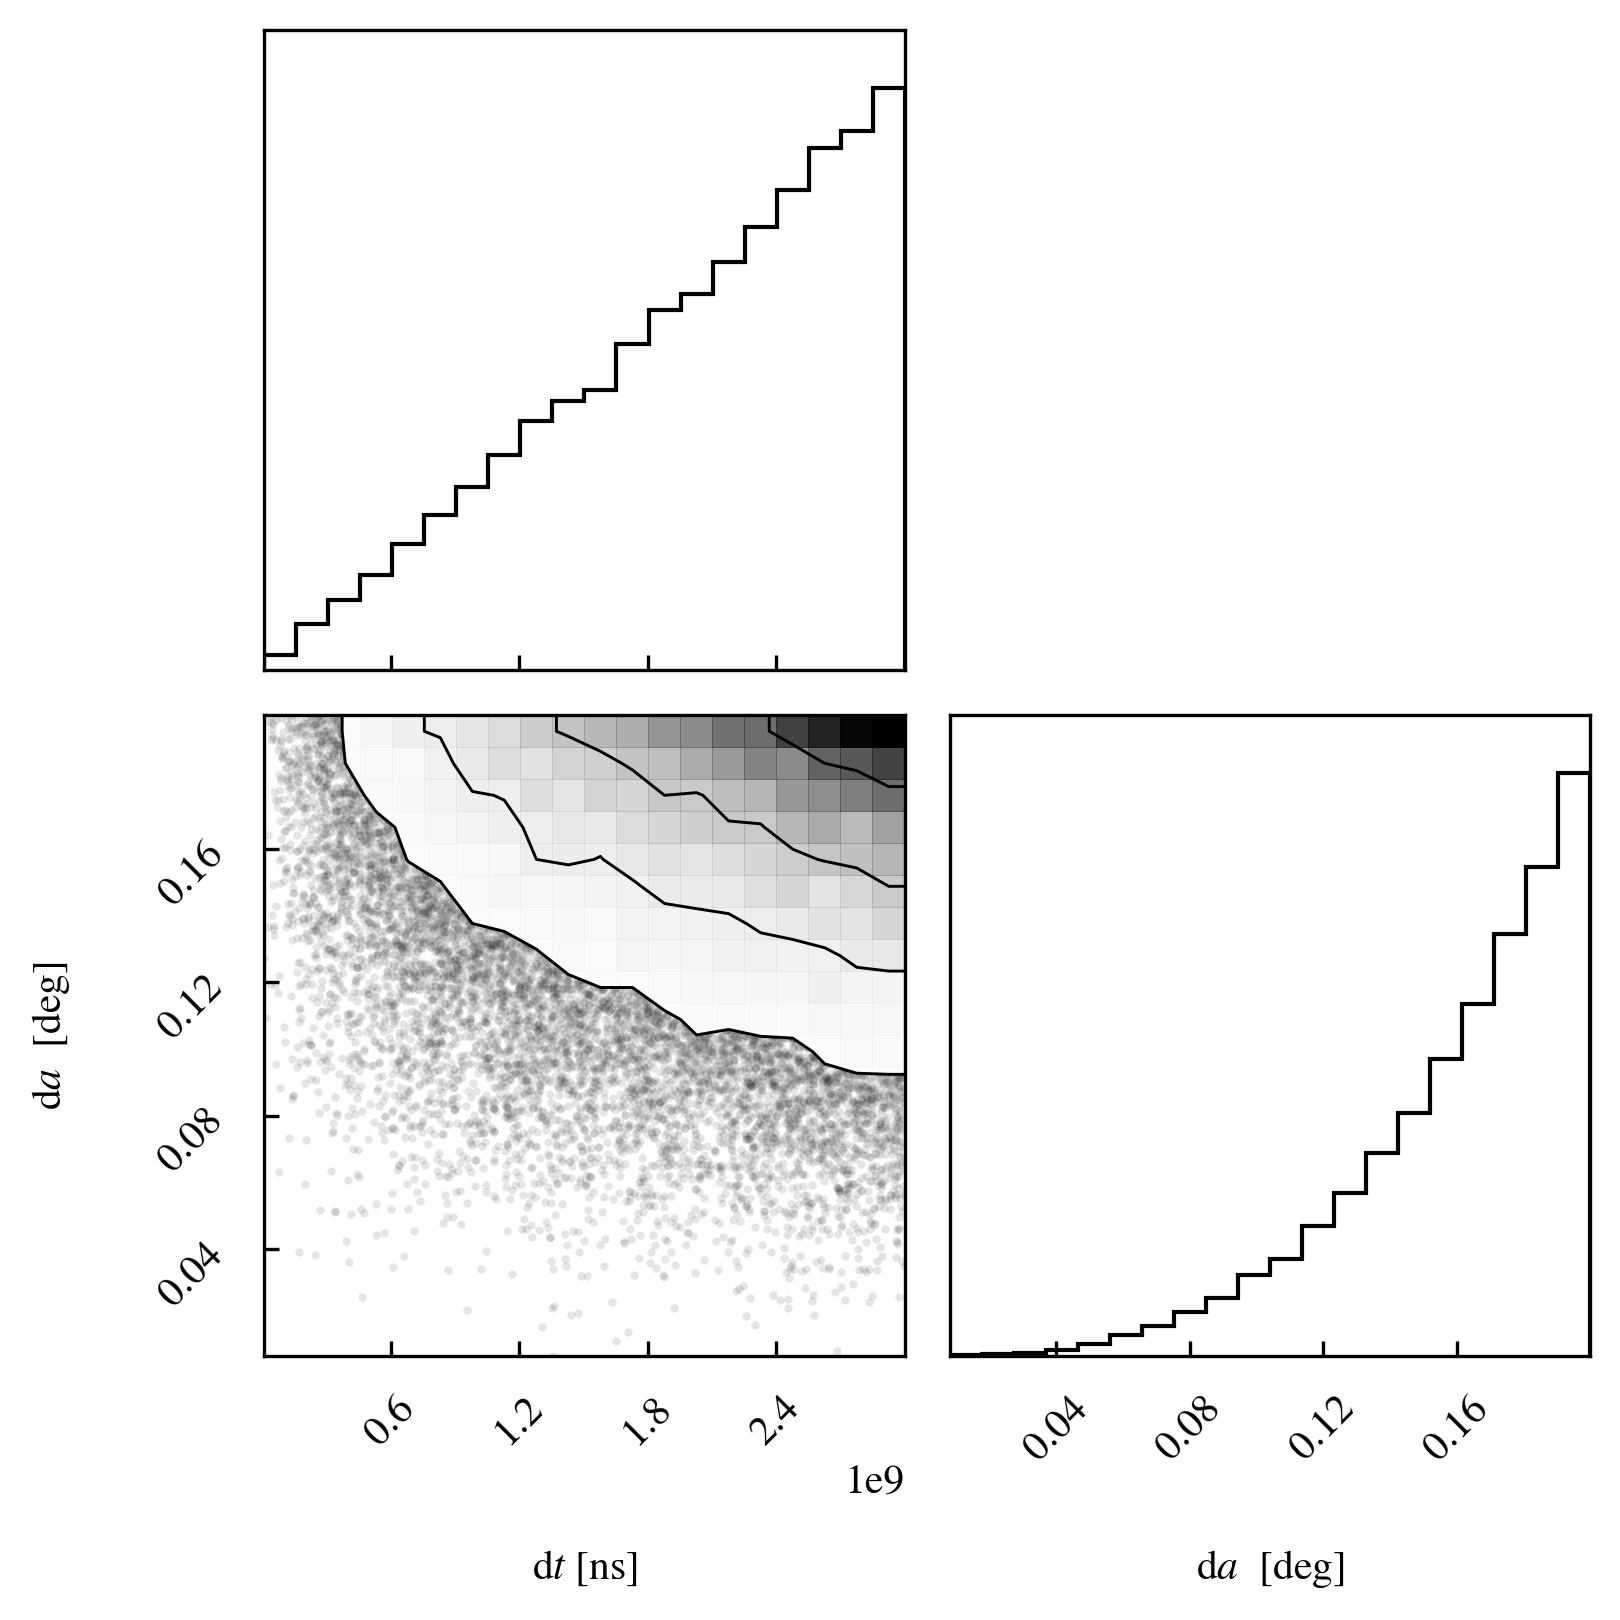

In [6]:
# plotting mplet results
from corner import corner
from matplotlib import figure

fig: figure.Figure = corner(mplets.table.to_pandas(),var_names=["dt","da"], labels=[r"$\mathrm{d}t$ [ns]", r"$\mathrm{d}a$  [deg]"])
for ax in fig.get_axes():
    for spine in ["right","top"]:
        ax.spines[spine].set_visible(True)
fig.savefig("figures/combined/n3_corner_dt_da.png",facecolor="white",dpi=300)

TeVCat distance histogram (keep!)

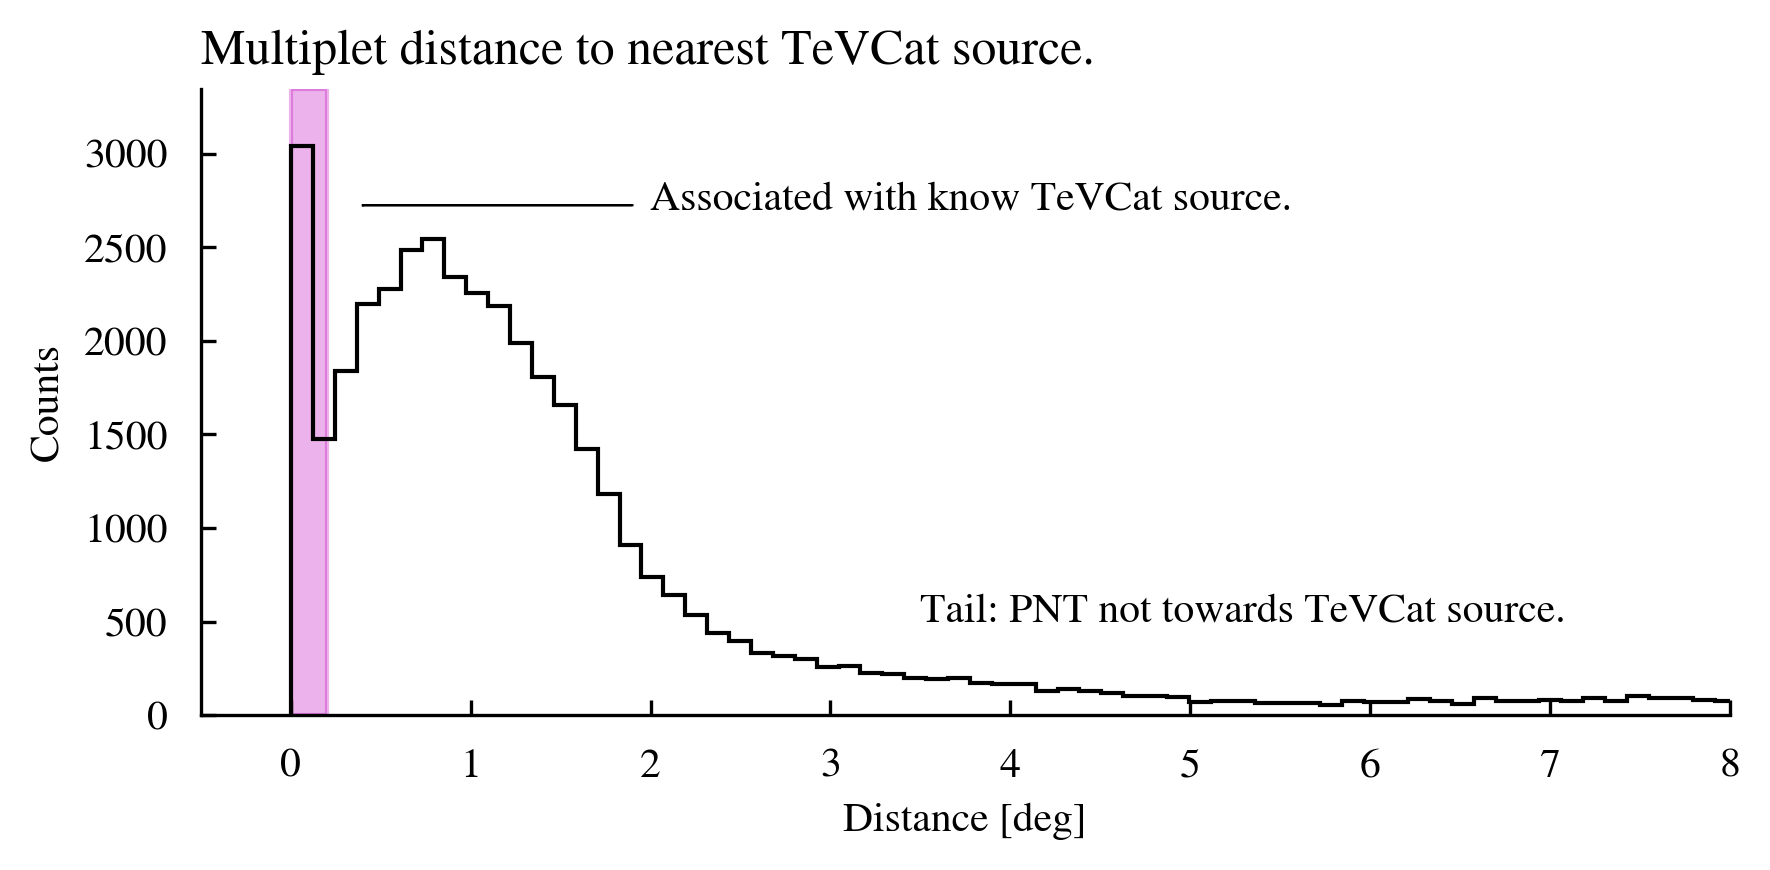

In [46]:
current_mask = nosource_mask
from matplotlib.figure import Axes

vline_sourcebound = .2
plt.figure(figsize=(6,3))
hist = vis.hist(mplets.table["TEVCAT_DISTANCES_DEG"],bins="freedman",histtype="step",stacked=True)
ax: Axes = plt.gca()
ax.set_title("Multiplet distance to nearest TeVCat source.",loc="left")
ax.set_xlabel("Distance [deg]")
ax.set_ylabel("Counts")
ylim = ax.get_ylim()
# ax.vlines(vline_sourcebound,0,ylim[1],color="red",ls="--",label=f"{vline_sourcebound} deg")
# ax.set_yscale("log")
ax.set_xlim(-.5,8)
ax.fill_between([0,vline_sourcebound],*ylim, alpha=0.3, color="m",label="Associated with TeVCat source.")
ax.text(2, 2650 + 50, "Associated with know TeVCat source.")
ax.arrow(1.9,2675 + 50,-1.5,0, lw=0.5)

# ax.fill_between([5,20],ylim[0],ylim[1]/5,color="green",alpha=0.3)
ax.text(3.5,5e2,"Tail: PNT not towards TeVCat source.")
ax.set_ylim(*ylim)
# ax.legend()
# ax.set_xscale("log")
plt.savefig("figures/combined/sourcedist_hist_makeup.png",facecolor="white")

HEALPix

In [ ]:
fig = plt.figure(dpi=300)

Nmax_mask = mplets.table["Nmax"] >= 4
dt_mask = mplets.table["dt"] <= 1e9
current_mask = nosource_mask*Nmax_mask*dt_mask

cmap = cm.jet
cmap.set_bad("r")
NSIDE = 2**5
m = scani.cat2hpx(mplets.table[current_mask]["MEDIAN_RA"],mplets.table[current_mask]["MEDIAN_DEC"],nside=NSIDE)
print(np.sqrt(hp.nside2pixarea(NSIDE,degrees=True)))
mmin, mmax = min(m),max(m)

hp.mollview(m,cmap=cmap, hold=True,nest=False,min=mmin,max=mmax,notext=True,fig=1,cbar=False,title="Transient tool applied on all H.E.S.S. data.")
#create a colorbar axis
cax = fig.add_axes([0.125, 0.1, 0.775, 0.03])

#create a colorbar and normalise it
# cmap.set_under("white")
# axs = fig.get_axes()
# axs[0].images[0].set_norm(colors.SymLogNorm(100))
cb = mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=mpl.colors.Normalize(vmin=mmin,vmax=mmax),
                               orientation='horizontal')
cb.set_label("Counts")
cb.solids.set_edgecolor("face")

plt.show()
# plt.savefig("figures/combined/healpy.png",facecolor="white")

Nmax histogram

Nmax left after mask: 5


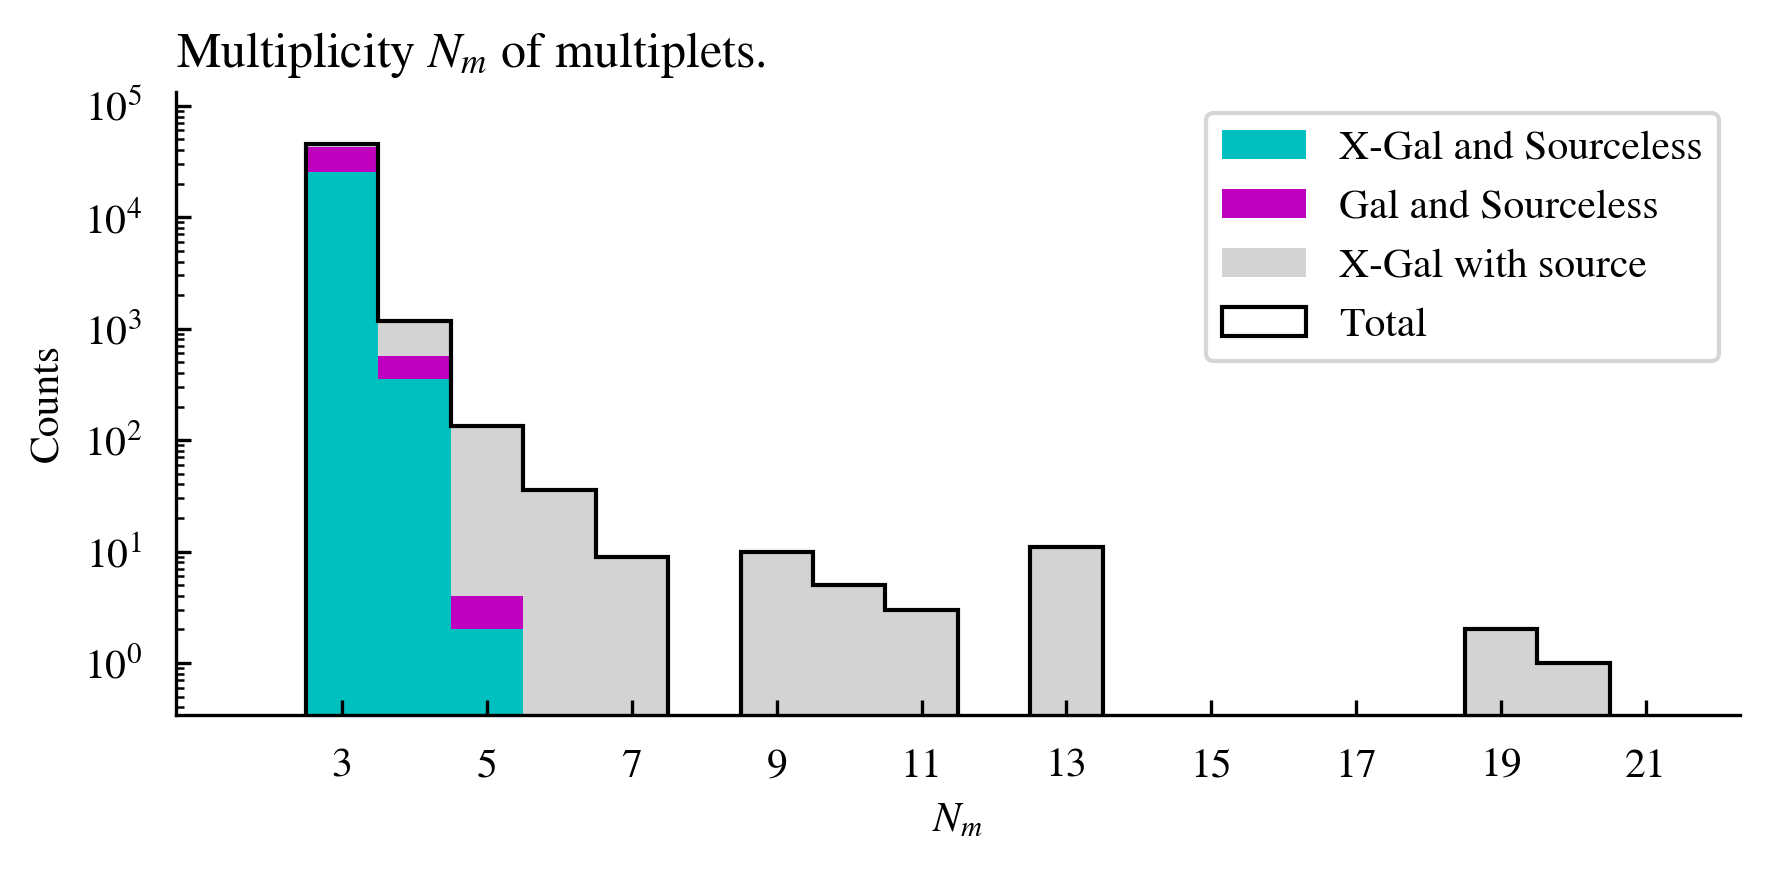

In [42]:
totalmask = nosource_mask * xgal_mask
nos = nosource_mask * ~xgal_mask
xgal = ~nosource_mask * xgal_mask


remaining_Nmax = max(mplets.table[totalmask]["Nmax"])
print(f"Nmax left after mask: {remaining_Nmax}")
nmax_data = mplets.table["Nmax"]
plt.figure(figsize=(6,3))
n,bins,_ = plt.hist([nmax_data[totalmask],nmax_data[nos],nmax_data[xgal]],bins=range(3,22),histtype="bar",stacked=True,color=["c","m","lightgrey"],label=["X-Gal and Sourceless","Gal and Sourceless","X-Gal with source"],align="left")
plt.hist(nmax_data,color="black",histtype="step",bins=bins,label="Total",align="left")
ax = plt.gca()
ax.set_xlabel("$N_m$")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.legend()
ax.set_xticks(range(3,22,2))
ax.set_title("Multiplicity $N_m$ of multiplets.",loc="left")
# plt.show()
plt.savefig("figures/combined/Nmax_hist.png",facecolor="white",dpi=300)

In [ ]:
# current_mask = nosource_mask# * mplets.table["Nmax"] > 3
temp = mplets.table[current_mask]["Nmax","OBS_ID","dt","da","MEDIAN_GLAT","TEVCAT_SOURCE_NAME","TEVCAT_SOURCE_TYPE","TEVCAT_DISTANCES_DEG"]
temp[:]

In [ ]:
temp.sort["Nmax"]

In [ ]:
Nmax = 3
run_count_rate = 1/60
expected_photons_3sec = 3*run_count_rate

expected_photons_3sec

In [ ]:
from math import factorial
sum = 1

for i in range(Nmax):
    sum -= expected_photons_3sec**(i)*np.exp(-expected_photons_3sec)/(factorial(i))
sum
                                                                      
                                                                    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

@np.vectorize
def pvalue(lamb):
    Nmax = 3
    sum = 1
    for i in range(Nmax):
        sum -= lamb**(i)*np.exp(-lamb)/(factorial(i))
    return sum

dt = np.geomspace(0.1,3,10)
lamb = (1/60)*dt
pval = pvalue(lamb)
plt.scatter(dt,pval)
plt.xscale("log")
plt.yscale("log")
    
